* * *
<pre> INSEA                <i> Projet Statistiques Multivariées - 2025 </i></pre>
* * *


<pre align="left"> Mardi 4 Novembre  2025             <i> Author: Hicham Janati </i></pre>
* * *

Consignes:
----------
- Deadline: *Dimanche 7 Décembre 23h59* | tout retard d'1h = -1
- Tout travail doit être effectué par groupe de deux sans exception.
- Il faut nommer le fichier avec le numéro du groupe seulement `groupe_X.ipynb` pas de noms. 
- PAS DE PDF NI DE FICHIER WORD. UN NOTEBOOK UNIQUEMENT.
- Les noms des membres du groupe sont à mentionner en modifiant la ligne suivante:

Membre 1:

Membre 2:

- Ce notebook contient 15 questions.
- Il faut executer tout le notebook (Run all cells) avant de l'envoyer: vérifier que les cellules sont exécutées dans le bon ordre et qu'il n'y a pas d'erreur, je ne vais pas débugger votre code. 
- Le code doit être propre et lisible et surtout comprendre ce qu'il fait par tous les membres du groupe.
- LIVRAISON UNIQUEMENT SUR DROPBOX (TOUT FICHIER ENVOYE PAR MAIL NE SERA PAS OUVERT):

https://www.dropbox.com/request/bs2Tafzm0Bzr7rroAGtc

Vous pouvez effectuer plusieurs uploads, seule la date la plus récente sera corrigée.

- Le but n'est pas de produire du code qui marche: le but est de comprendre et maîtriser les mécanismes derrière et savoir utiliser quoi et quand. Ce notebook est loin d'être self-contained, cherchez, lisez et apprenez à devenir auto-didacte.

# Partie 1: Les données

Les données sont coupés en deux: train et test. Il s'agit d'une liste d'SMS avec leur labels (Y) spam / non spam.

In [1]:
import numpy as np

X_train = np.load("data/X_train.npy", allow_pickle=True)
X_test = np.load("data/X_test.npy", allow_pickle=True)
Y_train = np.load("data/Y_train.npy", allow_pickle=True)
Y_test = np.load("data/Y_test.npy", allow_pickle=True)


In [2]:
X_train[:4], Y_train[:4]

(array(['Play w computer? Aiyah i tok 2 u lor?',
        "Well there's not a lot of things happening in Lindsay on New years *sighs* Some bars in Ptbo and the blue heron has something going",
        'Dear are you angry i was busy dear',
        "Carlos'll be here in a minute if you still need to buy"],
       dtype=object),
 array([0, 0, 0, 0]))

On rappelle que les données de `test` doivent être utilisées pour évaluer le modèle final comme si elles étaient nouvelles en production -- non disponibles à l'entraînement -- toute opération d'apprentissage (y compris la validation croisée) doit être faite sur les données `train` uniquement.

### Question 1
En utilisant ```CountVectorizer``` de ```scikit-learn``` transformez les données. Quelle est l'utilité de cette opération ?

```CountVectorizer``` construit un vocabulaire de mots à partir des SMS d’entraînement, puis représente chaque SMS par un vecteur de dimension V (où V = taille du vocabulaire).

Chaque coordonnée du vecteur contient le nombre d’occurrences du mot correspondant dans le SMS (représentation bag-of-words).

L’utilité de cette étape est de transformer les données textuelles (strings) en features numériques que les modèles de machine learning peuvent utiliser. Sans cette étape, les algorithmes ne peuvent pas traiter les SMS directement.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# 1) Créer le vectorizer
count_vect = CountVectorizer()   # vous pouvez plus tard limiter vocab, retirer stopwords, etc.

# 2) Apprendre le vocabulaire sur le train + transformer X_train
X_train_counts = count_vect.fit_transform(X_train)

# 3) Transformer X_test avec le même vocabulaire (IMPORTANT: pas de fit ici) Éviter le "data leakage"
X_test_counts = count_vect.transform(X_test)

# Quelle est l'utilité de cette opération ?
'''L’utilité de cette étape est de transformer les données textuelles (strings) en features numériques que les modèles 
de machine learning peuvent utiliser. Sans cette étape, les algorithmes ne peuvent pas traiter les SMS directement.'''

'L’utilité de cette étape est de transformer les données textuelles (strings) en features numériques que les modèles \nde machine learning peuvent utiliser. Sans cette étape, les algorithmes ne peuvent pas traiter les SMS directement.'

#### Question 2:
On modélise les données de chaque classe par une loi multinomiale. En utilisant ```MultinomialNB``` de scikit-learn, fittez un modèle et évaluez sa performance en calculant les scores de précision et de rappel.

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, classification_report

# 1) Créer le modèle
nb_clf = MultinomialNB()

# 2) Apprentissage
nb_clf.fit(X_train_counts, Y_train)

# 3) Prédiction
Y_pred = nb_clf.predict(X_test_counts)

In [5]:
print(classification_report(Y_test, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9832    0.9950    0.9891      2413
           1     0.9651    0.8901    0.9261       373

    accuracy                         0.9810      2786
   macro avg     0.9742    0.9426    0.9576      2786
weighted avg     0.9808    0.9810    0.9806      2786



### Question 3:
Implémentez votre propre modèle naive bayes multinomial en utilisant numpy. Comparez avec scikit-learn.

In [6]:
import numpy as np

class MyMultinomialNB:

    def __init__(self, alpha=1.0):
        self.alpha = alpha  # lissage de Laplace

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape

        # P(y)
        self.class_count_ = np.array([np.sum(y == c) for c in self.classes])
        self.class_log_prior_ = np.log(self.class_count_ / n_samples)

        # Comptage des mots par classe
        self.feature_count_ = np.zeros((len(self.classes), n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.feature_count_[idx, :] = X_c.sum(axis=0)

        # P(x_i | y=c) avec lissage
        self.feature_log_prob_ = np.log(
            (self.feature_count_ + self.alpha) /
            (self.feature_count_.sum(axis=1).reshape(-1, 1) + self.alpha * n_features)
        )

    def predict(self, X):
        log_probs = X @ self.feature_log_prob_.T + self.class_log_prior_
        return self.classes[np.argmax(log_probs, axis=1)]

In [7]:
my_nb = MyMultinomialNB(alpha=1.0)
my_nb.fit(X_train_counts, Y_train)

Y_pred_my = my_nb.predict(X_test_counts)

print(classification_report(Y_test, Y_pred_my, digits=4))


              precision    recall  f1-score   support

           0     0.9832    0.9950    0.9891      2413
           1     0.9651    0.8901    0.9261       373

    accuracy                         0.9810      2786
   macro avg     0.9742    0.9426    0.9576      2786
weighted avg     0.9808    0.9810    0.9806      2786



### Question 4:
Afin de comparer avec d'autres modèles qui s'attendent à des inputs continus, on peut utiliser des fréquences de mots au lieu du nombre brut. Appliquez la transformation `TfIdf` de scikit-learn sur les données. Fittez des modèles différents: LDA, régression logistique, QDA et SVM. Essayez de battre la performance du MulinomialNB. 

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()

X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_tfidf  = tfidf.transform(X_test_counts)

In [9]:
'''TF-IDF réduit l’importance des mots trop fréquents (“the”, “you”, “free”) et valorise les mots discriminants.'''

'TF-IDF réduit l’importance des mots trop fréquents (“the”, “you”, “free”) et valorise les mots discriminants.'

In [10]:
# Classifieur Logistic Regression
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=2000)
log_clf.fit(X_train_tfidf, Y_train)
Y_pred_log = log_clf.predict(X_test_tfidf)

print(classification_report(Y_test, Y_pred_log, digits=4))

              precision    recall  f1-score   support

           0     0.9567    0.9992    0.9775      2413
           1     0.9925    0.7078    0.8263       373

    accuracy                         0.9602      2786
   macro avg     0.9746    0.8535    0.9019      2786
weighted avg     0.9615    0.9602    0.9573      2786



In [11]:
# LDA (nécessite des données denses)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_tfidf.toarray(), Y_train)
Y_pred_lda = lda.predict(X_test_tfidf.toarray())

print(classification_report(Y_test, Y_pred_lda, digits=4))
'''⚠️ LDA marche souvent moins bien sur du texte (données trop haute dimension).'''

              precision    recall  f1-score   support

           0     0.9633    0.8591    0.9082      2413
           1     0.4637    0.7882    0.5839       373

    accuracy                         0.8496      2786
   macro avg     0.7135    0.8237    0.7461      2786
weighted avg     0.8964    0.8496    0.8648      2786



'⚠️ LDA marche souvent moins bien sur du texte (données trop haute dimension).'

In [12]:
# QDA (ne fonctionne presque jamais avec des milliers de features → singularité.)
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca  = pca.transform(X_test_tfidf.toarray())

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_pca, Y_train)
Y_pred_qda = qda.predict(X_test_pca)

print(classification_report(Y_test, Y_pred_qda, digits=4))


              precision    recall  f1-score   support

           0     0.9728    0.9478    0.9601      2413
           1     0.7103    0.8284    0.7649       373

    accuracy                         0.9318      2786
   macro avg     0.8416    0.8881    0.8625      2786
weighted avg     0.9376    0.9318    0.9340      2786



c:\Users\zikob\OneDrive\Desktop\Project-NLP\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [13]:
# SVM
from sklearn.svm import LinearSVC

svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, Y_train)
Y_pred_svm = svm_clf.predict(X_test_tfidf)

print(classification_report(Y_test, Y_pred_svm, digits=4))


              precision    recall  f1-score   support

           0     0.9820    0.9959    0.9889      2413
           1     0.9705    0.8820    0.9242       373

    accuracy                         0.9806      2786
   macro avg     0.9763    0.9389    0.9565      2786
weighted avg     0.9805    0.9806    0.9802      2786



### Question 5:
Visualisez la PCA et tSNE des données transformées.


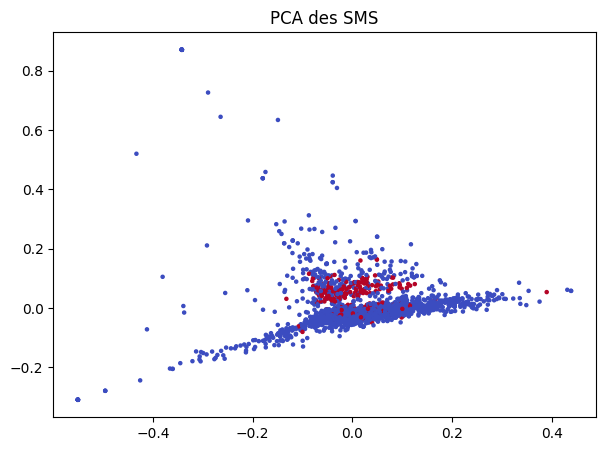

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y_train, cmap='coolwarm', s=5)
plt.title("PCA des SMS")
plt.show()

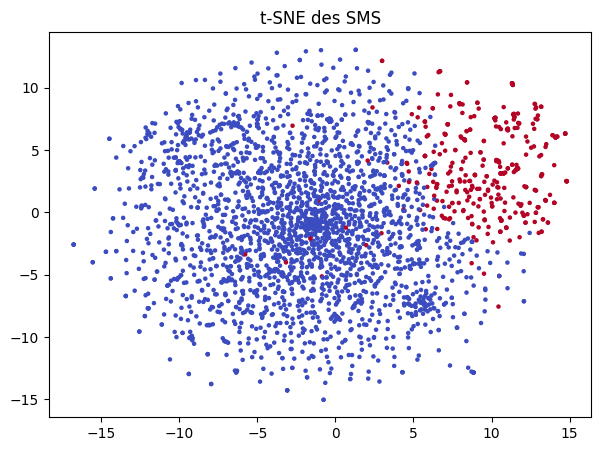

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
X_tsne = tsne.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(7,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=Y_train, cmap='coolwarm', s=5)
plt.title("t-SNE des SMS")
plt.show()

# Partie II: Introduction au NLP

Dans cette partie on utilise des transformations plus avancées basées sur la factorisation matricielle. L'un des premiers modèles à grand succès pour représenter les mots est `Word2Vec`. Étant donné un vocabulaire de taille V, on peut représenter un input par un vecteur binaire de taille V (one-hot encoding). Par exemple si le vocabulaire est
```["rouge", "chat", "souris", "courir", "mange", "ordinateur", "la", "le", ...]``` 
Alors on peut représenter chaque mot par son vecteur one-hot de taille V:
- "chat" -> [0, 1, 0, 0, 0, ...]
- "ordinateur" -> [0, 0, 0, 0, 0, 1, 0, ...]

La phrase "le chat mange la souris" peut être représentée par [0, 1, 1, 0, 1, 0, 1, 1, ...].

On construit un réseau de neurones simple capable de prédire le mot manquant au milieu d'une phrase avec des données comme:
- "le chat la souris" -> "mange"
- "la matrice est pas inversible" -> "n'" 
...
Ainsi, l'input du réseau doit être un vecteur de taille V. L'output doit être également **un vecteur de probabilités** de taille V. On prédit le mot avec la plus grande probabilité.

On considère un réseau de neurones à une couche cachée de dimension M (M neurones). Le réseau de neurones doit en sortie prédire un mot caché. Soit $x \in \mathbb R^V$ un one-hot vecteur. Le réseau de neurones peut être défini formellement comme suit. Soit $W_{in} \in \mathbb{R}^{V \times M}$ et $W_{out} \in \mathbb{R}^{M \times V}$. 

$$ g(x) = W_{out}(W_{in}x) \in \mathbb R^{V} $$

Pour obtenir un vecteur output positif et sommant à 1 (des probabilités sur les mots), on applique la fonction softmax:
$$ softmax: z \in \mathbb R^V \mapsto \left[\frac{e^{z_1}}{\sum_j e^{z_j}}, \dots, \frac{e^{z_V}}{\sum_j e^{z_j}}  \right]^\top$$

Ainsi on définit: $ neuralnet(x) = softmax(g(x))$ et on entraîne le modèle avec la loss cross-entropy.
 
Après avoir entraîné le modèle, les ligne de la matrice $W_{in}$ sont les embeddings des mots du vocabulaire.


On commence par télécharger le modèle word2vec (peut prendre du temps):

In [14]:
import gensim.downloader as api

word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


word2vec est n'est qu'un dictionnaire spécial "mot" -> vecteur:


In [15]:
word2vec["computer"]

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

On peut obtenir l'embedding de plusieurs mots directement dans une liste. L'embedding d'une phrase est souvent défini comme la moyenne des embeddings de ses mots.

In [16]:
word2vec[["computer", "mouse", "keyboard"]].shape

(3, 300)

In [ ]:
word2vec[["I", "love", "computers"]].mean(axis=0).shape

(300,)

### Question 6
Pour appliquer word2vec aux SMS, il faut d'abord les découper en mots. Implémentez une fonction naïve qui transforme un SMS en liste de mots ou _tokens_. C'est ce qu'on appelle un tokenizer.

In [28]:
import re

def tokenizer(text):
    # retire la ponctuation + séparation espaces
    text = text.lower()
    tokens = re.findall(r"[a-zA-Z0-9']+", text)
    return tokens

### Question 7
On peut vérifier si un mot fait partie du vocabulaire avec le test:

In [29]:
"computer" in word2vec

True

Proposez une solution pour appliquer word2vec aux données SMS. Est-il meilleur comme embedding comparé au `CountVectorizer` ?

1) Idée générale

Tokeniser chaque SMS (on peut réutiliser la fonction de Q6).

Entraîner un modèle Word2Vec sur l’ensemble des SMS tokenisés.

Pour chaque SMS, construire un embedding de phrase = moyenne des vecteurs des mots.

Entraîner un classifieur (Logistic Regression / SVM) sur ces embeddings.

Comparer les métriques (précision, rappel, f1) avec TF-IDF ou CountVectorizer.

In [ ]:
from gensim.models import Word2Vec

# 1) Tokenisation de tous les SMS
def tokenizer(text):
    import re
    text = text.lower()
    tokens = re.findall(r"[a-zA-Z0-9']+", text)
    return tokens

X_train_tokens = [tokenizer(x) for x in X_train]
X_test_tokens  = [tokenizer(x) for x in X_test]

# 2) Entraînement du modèle Word2Vec
w2v_dim = 100  # dimension des embeddings
w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=w2v_dim,
    window=5,
    min_count=2,
    workers=4
)

# 3) Embedding d'un SMS = moyenne des vecteurs des mots
import numpy as np

def sms_embedding(tokens, model, dim):
    vecs = []
    for tok in tokens:
        if tok in model.wv.key_to_index:   # le mot est dans le vocabulaire
            vecs.append(model.wv[tok])
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_train_w2v = np.vstack([sms_embedding(toks, w2v_model, w2v_dim) for toks in X_train_tokens])
X_test_w2v  = np.vstack([sms_embedding(toks, w2v_model, w2v_dim) for toks in X_test_tokens])

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_w2v = LogisticRegression(max_iter=2000)
clf_w2v.fit(X_train_w2v, Y_train)

Y_pred_w2v = clf_w2v.predict(X_test_w2v)
print(classification_report(Y_test, Y_pred_w2v, digits=4))

              precision    recall  f1-score   support

           0     0.8661    1.0000    0.9283      2413
           1     0.0000    0.0000    0.0000       373

    accuracy                         0.8661      2786
   macro avg     0.4331    0.5000    0.4641      2786
weighted avg     0.7502    0.8661    0.8040      2786



c:\Users\zikob\OneDrive\Desktop\Project-NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zikob\OneDrive\Desktop\Project-NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zikob\OneDrive\Desktop\Project-NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

`Word2vec` (2013) est l'un des premiers modèles de représentation vectorielle du langage naturel. L'une de ses limitations principales est le fait de ne pas pouvoir représenter des mots (ou bouts de mots) non-vus lors de l'entraînement. Quelques années plus tard, plusieurs avancées ont été introduites pour y remédier:

### 1) Améliorer la tokenization:
1. Au lieu de considérer un vocabulaire avec des mots, on considère un vocabulaire avec les mots, et les bouts de mots (ngrams):

    "diagonalisation matricielle" -> "diagonal", "isation", " ", "matric", "ielle". 

    Ceci est utilisé dans le modèle `fastText` (2016) dont l'architecture est similaire à celle de Word2Vec.

2. WordPiece: approche bottom-up où le vocabulaire des tokens est construit en mergeant les caractères (a-Z, 0-9, symboles et ponctuation) + Ajouter des tokens spéciaux "[UNK]" (unknow) pour gérer les tokens non-vus, "[SEP]" (séparateur entre phrases ou textes), "[MASK]" (token qui veut dire "ce mot est à prédire") etc. Ce tokenizer est utilisé dans l'un des premiers modèles basés sur l'architecture Transformer (BERT) (2018).

3. Byte-pair encoding (BPE): similaire à WordPiece mais à l'échelle du byte.  Ceci permet d'encoder n'importe quel string dans n'importe quelle langue: mots rares, typos, emojis, kanji... C'est le tokenizer adopté par l'un des fameux modèles de traduction à l'époque (Neural Machine Translation -- NMT 2015) pour traduire les mots rares; et ensuite par les modèles GPT (2018). Avec BPE, on n'a plus besoin du token spécial _unknown_ [UNK]. Vous pouvez voir comment le texte est tokenisé par GPT en visitant https://platform.openai.com/tokenizer. 

### 2) Améliorer l'architecture

1. Limites de Word2Vec et companie:

La nature des données de langage est séquentielle (comme les séries temporelles, mot après mot..), or les modèles comme Word2Vec et ses variantes (Fasttext, GloVe) ne prennent pas en considération l'ordre des mots: ils sont appliqués à des _bag of words_. En plus, même si ses modèles utilisent le contexte voisin, après l'entraînement, l'embedding d'un mot est le même quelque soit son contexte ce qui limite la compréhension des différentes nuances d'un même mot. 

2. Recurrent Neural Networks:

L'architecture des réseaux de neurones récurrents (RNN) et ses variantes (LSTM, GRU) développés principalement dans les années 1990 sont revisités en (2013-2020) après le succès du deep learning (2012+) avec la réalisation de la grande puissance de calcul des GPUs. Ils permettent de prendre en considération l'aspect temporel des données mais restent difficiles à entraîner (nécessitent beaucoup de temps + instabilité des gradients). 

3. Transformers (en très bref):

En 2017, l'architecture des Transformers est introduite. Son avantage principal est son formalisme matriciel qui est beaucoup plus parallélisable que les RNNs, et donc permet d'entraîner des modèles plus grands sur des données beaucoup plus grandes. Prenons le cas d'une architecture générative (GPT). Un transformer définit une structure appelée _Self-Attention Head_ qui fonctionne comme suit.
Étant donnés les embeddings (statiques comme ceux de Word2Vec) des tokens d'une phrase, le mécanisme d'attention consiste à calculer des scores de similarités (produits scalaires) entre chaque paire d'embeddings, ceci permet d'obtenir une matrice de scores "d'attention" entre les tokens.

Par exemple, pour une phrase "Il me faut un tapis pour la souris Logitec", l'embedding du mot "souris" sera pondéré par ses scores de similarité avec chacun des autres mots ["Il", "me", "faut", "un", "tapis", "pour", "la", "logitec"]. Ainsi, l'embedding d'un même mot dépend du contexte. Ceci permettra de distinguer la souris (animal) de la souris d'ordinateur.

 Ceci reste une explication très simpliste du mécanisme d'attention, pour visualiser le concept, regardez la vidéo de 3b1b https://www.youtube.com/watch?v=eMlx5fFNoYc.







## III Partie 3 - Embeddings basés sur les transformers

Dans cette partie, on passe à l'artillerie lourde: embeddings basés sur les transformers. On utilise ceux de BERT plutôt que GPT car BERT a été conçu pour la classification supervisée alors que GPT pour la génération de texte: l'embedding de BERT est plus pertinent pour notre problématique.

On commence par tokeniser les données. Voici ce que donne le tokenizer avec une phrase par exemple:

In [19]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


c:\Users\zikob\OneDrive\Desktop\Project-NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\zikob\OneDrive\Desktop\Project-NLP\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zikob\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In

In [20]:
text = "Hey, are you free tomorrow at 8 ? gotta catch up bud."
tokens = tokenizer.tokenize(text)
tokens


['hey',
 ',',
 'are',
 'you',
 'free',
 'tomorrow',
 'at',
 '8',
 '?',
 'gotta',
 'catch',
 'up',
 'bud',
 '.']

Le modèle BERT en revanche ne s'attend pas à des tokens en texte, mais aux token_ids:

In [21]:
text = "Hey, are you free tomorrow at 8 ? gotta catch up bud"
token_ids = tokenizer(text, return_tensors="pt")
token_ids


{'input_ids': tensor([[  101,  4931,  1010,  2024,  2017,  2489,  4826,  2012,  1022,  1029,
         10657,  4608,  2039, 13007,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

On fait appel ensuite au modèle BERT. On peut voir les composants de son architecture:

In [22]:
bert_model = AutoModel.from_pretrained("bert-base-uncased")
bert_model.eval()
bert_model


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

On applique le modèle aux token_ids sans calcul de gradient:

In [23]:
import torch
with torch.no_grad():
    outputs = bert_model(**token_ids)
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3836,  0.0548, -0.0066,  ..., -0.2580,  0.3390,  0.2724],
         [ 0.6628, -0.0560,  0.9965,  ...,  0.0643,  1.2164, -0.4075],
         [ 0.1342,  0.0883,  0.7119,  ..., -0.0816,  1.2578,  0.1409],
         ...,
         [ 0.8804, -0.9000,  0.7776,  ...,  0.3333,  0.4174, -0.7230],
         [ 0.4084, -0.3247,  0.8299,  ...,  0.8601,  0.5027, -0.3476],
         [ 0.4914,  0.0527, -0.1084,  ..., -0.1167, -0.4205, -0.2667]]]), pooler_output=tensor([[-8.6382e-01, -5.2100e-01, -9.1143e-01,  7.4742e-01,  6.9650e-01,
         -2.0079e-01,  8.5602e-01,  3.7551e-01, -7.7920e-01, -9.9999e-01,
         -4.6733e-01,  8.6761e-01,  9.8091e-01,  5.1904e-01,  9.3339e-01,
         -7.2372e-01, -2.1201e-01, -6.3463e-01,  3.1704e-01, -3.3231e-01,
          7.0444e-01,  9.9999e-01,  5.4936e-02,  3.5607e-01,  5.5947e-01,
          9.8429e-01, -7.8516e-01,  9.2725e-01,  9.5860e-01,  7.1539e-01,
         -6.2374e-01,  1.7224e-01, -

On peut accéder aux embeddings en cherchant la dernière couche cachée:

In [24]:
outputs.last_hidden_state

tensor([[[ 0.3836,  0.0548, -0.0066,  ..., -0.2580,  0.3390,  0.2724],
         [ 0.6628, -0.0560,  0.9965,  ...,  0.0643,  1.2164, -0.4075],
         [ 0.1342,  0.0883,  0.7119,  ..., -0.0816,  1.2578,  0.1409],
         ...,
         [ 0.8804, -0.9000,  0.7776,  ...,  0.3333,  0.4174, -0.7230],
         [ 0.4084, -0.3247,  0.8299,  ...,  0.8601,  0.5027, -0.3476],
         [ 0.4914,  0.0527, -0.1084,  ..., -0.1167, -0.4205, -0.2667]]])

### Question 8
Expliquez la dimension obtenue de ces embeddings. On souhaite obtenir les embeddings de toutes les données directement. Appliquez la tokenization à la liste de textes suivante. Quel problème se pose ? Comment y remédier ?

In [25]:
texts = ["Hey, are you free tomorrow at 8 ? gotta catch up bud.", "Sure thing, let's go."]
token_ids = tokenizer(texts, return_tensors="pt")


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

### Question 9
Après avoir fixé le problème, analysez les tokens obtenus et le `attention_mask` de l'output. Comment peut-on savoir où le `padding` a été appliqué ?

### Question 10
L'embedding d'une phrase est la moyenne des embeddings de ses tokens. Appliquez BERT à une liste des donnés spams (X_train[:10]). Calculez le temps pris par cette opération en utilisant la librairie `time`. 

### Question 11
Avec une GPU, ce calcul peut être jusqu'à 100x fois plus rapide. On vous fournit les embeddings des données `X_train` et `X_test` calculés avec BERT. Refaire l'étape de visualisation et classification avec ces embeddings pour comparer. 

In [ ]:
import numpy as np
X_train_bert = np.load("data/embeddings_train.npy")
X_test_bert = np.load("data/embeddings_test.npy")


# IV Partie 4: Data drift 
En production, les données nouvelles peuvent devenir de plus en plus différentes des données d'entraînement avec le temps: on parle de _data drift_ ou de _distribution shift_. Il faut alors réentraîner le modèle sur des données plus récentes. 


### Question 12
Appliquez une PCA pour la réduire et implémentez un test statistique pour comparer les moyennes des embeddings Train et Test.

### Question 13
En pratique, comparer les moyennes des distributions n'est pas suffisant pour détecter le drift. Si on obtient les vrais labels (même avec un petit retard), alors  on peut calculer les métriques de performances (précision, rappel) au cours du temps. Sinon, on peut chercher à prédire si un échantillon vient du train ou du test ! L'idée est: si un modèle ML est capable de les distinguer: il y a forcément un drift. Trouvez le meilleur modèle capable de le faire en utilisant les embeddings de BERT. 

## V Partie 5: Modélisation non supervisée

#### Question 14
Sans utiliser les labels, modéliser en utilisant le modèle GMM de `scikit-learn` les données (BERT embeddings + PCA) en utilisant quelques modèles différents (nombre de composantes 2 vs 3 -- et type de covariance). Comparez les performances avec les vrais labels.

### Question 15
Comparez ces modèles en utilisant le test du rapport de vraisemblance. Quel est le modèle plausible le plus simple ?